<a href="https://colab.research.google.com/github/kishiyamat/la-kentei-yaminabe/blob/main/notebooks/tanuki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# タヌキと法の裁き

タヌキはムジナと弁別しづらいのか調査する。
ただし、弁別のしづらさは相対的なものとするので、
キツネとタヌキの弁別のしづらさから考察する。

## データのダウンロード

一時的に作成している環境にダウンロードするだけなので、
実行しても環境は汚染されません。

In [1]:
import requests
from zipfile import ZipFile

# 1. Google Driveからファイルをダウンロードする関数
def download_from_google_drive(file_id, filename):
    download_url = f"https://drive.google.com/uc?id={file_id}"
    response = requests.get(download_url, stream=True)
    response.raise_for_status()
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

# 2. Zipファイルをダウンロード
zip_filename = "tanuki.zip"
file_id = "1X8Jd4UDlglztXAfMJqaQysdYzClb_L__"
download_from_google_drive(file_id, zip_filename)

# 3. Zipファイルを解凍
with ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("tanuki")


In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.cluster import KMeans
from plotnine import *
import pandas as pd
import numpy as np

import glob
from pathlib import Path

# ファイルのリストを取得(FIXME: zipにする)
image_path_list = glob.glob('/content/tanuki/images/*.png')

# ディレクトリ内の画像ファイルを読み込む
images = []
labels = []
res = 32
for file in image_path_list:
    assert file.endswith('.png')
    img = Image.open(file).convert('L')  # グレースケールで読み込む
    img = img.resize((res, res))  # すべての画像を同じサイズにリサイズ
    images.append(np.array(img).flatten())  # 1次元配列に変換
    labels.append(Path(file).stem.split("_")[0])  # ラベルを取得

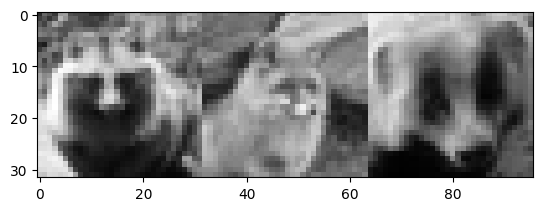

In [3]:
idxs = 20, 40, 50,
imgs = np.hstack([images[idx].reshape((res,res)) for idx in idxs])
plt.imshow(imgs, cmap='gray')

## クラスタリング

In [4]:
len(images)

144

In [5]:
labels[:6]

['ANG', 'ANG', 'ANG', 'TNK', 'ANG', 'ANG']

In [6]:
def shape(lab):
    if lab=="KTN":
        return "   |v|      "
    if lab=="TNK":
        return "|o|            "
    if lab=="ANG":
        return "|x|"

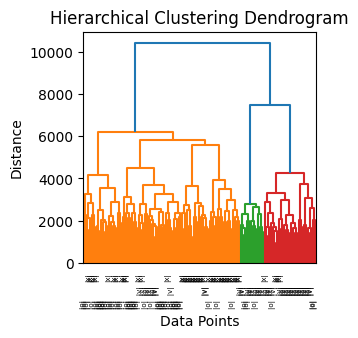

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

# 階層的クラスタリング（ユークリッド距離を使用）
Z = linkage(np.array(images), method='ward', metric='euclidean')

label_shapes = list(map(shape, labels))
# デンドログラムの作成
plt.figure(figsize=(3, 3))
dendrogram(Z, labels=label_shapes)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel('Data Points')
plt.ylabel('Distance')
# plt.show()

plt.savefig('dendrogram.png', dpi=600, bbox_inches='tight')

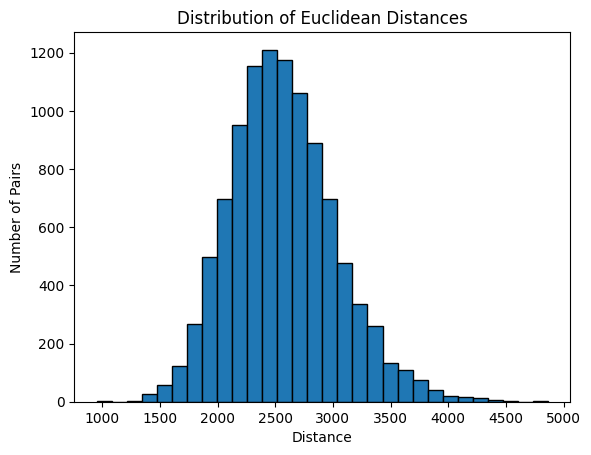

In [8]:
from scipy.spatial.distance import pdist, squareform
# ユークリッド距離を計算
distances = pdist(np.array(images), 'euclidean')
distance_matrix = squareform(distances)

# 距離の分布をヒストグラムで表示
plt.hist(distances, bins=30, edgecolor="k")
plt.title("Distribution of Euclidean Distances")
plt.xlabel("Distance")
plt.ylabel("Number of Pairs")
plt.show()

注意したいのは顔の画像が区別できないから種は画像から区別がつかないという結論にはならない。今回はかなり見た目を潰してしまっている。というのも、ピクセルごとの比較だから、黒い模様が丸い形とか耳の形が三角で、というような特徴は捉えていない。だとしても、キツネvs.タヌキの分かりやすさに対するタヌキvs.ムジナの分かりづらさは、デンドログラムでなかなか綺麗に分かれない結果からも支持できるのではないだろうか。

## Appendix: NMF

In [9]:
from sklearn.decomposition import NMF

# 真のラベル
# numpy配列に変換
images = np.array(images)

# NMFを用いてデータを2次元に削減（可視化のため）
nmf = NMF(n_components=2, init='random', random_state=0)
reduced_data = nmf.fit_transform(images)

# 結果をプロット
df = pd.DataFrame(reduced_data, columns=['DIM_1', 'DIM_2'])
df['label'] = labels

In [10]:
comp1 = ["TNK", "KTN"]
comp2 = ["TNK", "ANG"]
df_1 = df.query("label in @comp1")
df_1.loc[:, "compare"] = "TNK--KTN"
df_2 = df.query("label in @comp2")
df_2.loc[:, "compare"] = "TNK--ANG"
df_comp = pd.concat([df_1, df_2])
df_comp

<ipython-input-10-27e6947753fd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-10-27e6947753fd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,DIM_1,DIM_2,label,compare
3,8.552060,6.683829,TNK,TNK--KTN
6,10.752122,3.964179,TNK,TNK--KTN
8,8.927225,2.147261,TNK,TNK--KTN
9,7.929422,8.358726,TNK,TNK--KTN
12,9.974892,11.171580,KTN,TNK--KTN
...,...,...,...,...
138,10.078871,3.618544,TNK,TNK--ANG
139,11.865459,6.590702,ANG,TNK--ANG
140,14.618469,4.660094,ANG,TNK--ANG
141,8.349488,6.491250,TNK,TNK--ANG


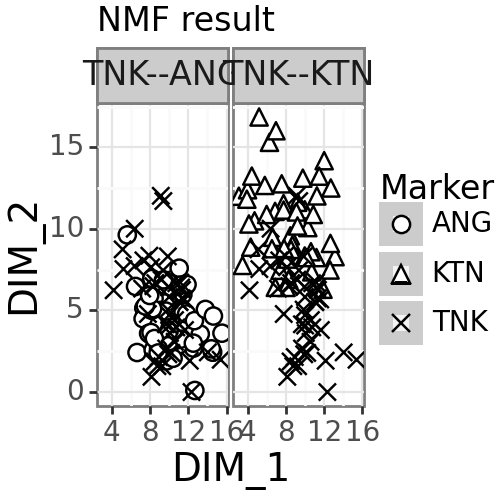

/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 2.5 x 2.5 in image.
/usr/local/lib/python3.10/dist-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ch02_tnk48.png


In [11]:
p = (
    ggplot(df_comp, aes(x='DIM_1', y='DIM_2', shape='label'))
    + facet_wrap("~compare", nrow=1)
    + geom_point(fill='white', color='black', size=3)# , alpha=0.1)
    + scale_shape_manual(values=['o', '^', 'x'])
    + labs(title="NMF result", x="DIM_1", y="DIM_2", shape="Marker")
    + theme_bw()  # Set the theme to black and white
    + theme(
        figure_size=(2.5, 2.5),  # in inch
        text=element_text(size=12),  # set the font size for the entire plot
        axis_title=element_text(size=14),  # set the font size for axis titles
        axis_text=element_text(size=10),  # set the font size for axis labels
        legend_title=element_text(size=12),  # set the font size for legend title
        legend_text=element_text(size=10),  # set the font size for legend labels
        legend_key=element_rect(size=10),  # set the size of legend keys
        )
)
print(p)
ggsave(p, filename = 'ch02_tnk48.png')

In [12]:
H = nmf.components_
img_y = []
for y in range(15, 2, -4):
    # 上から作る: yは大きい方から
    img_x = []
    for x in range(2, 15, 4):
        # 左から作る: xは小さい方から
        img_xy = ([x, y] @ H)
        img_xy = (img_xy - img_xy.min()) / (img_xy.max() - img_xy.min())
        img_xy = img_xy.reshape((res,res))
        img_x.append(img_xy)
    img_x = np.hstack(img_x)
    img_y.append(img_x)
img = np.vstack(img_y)

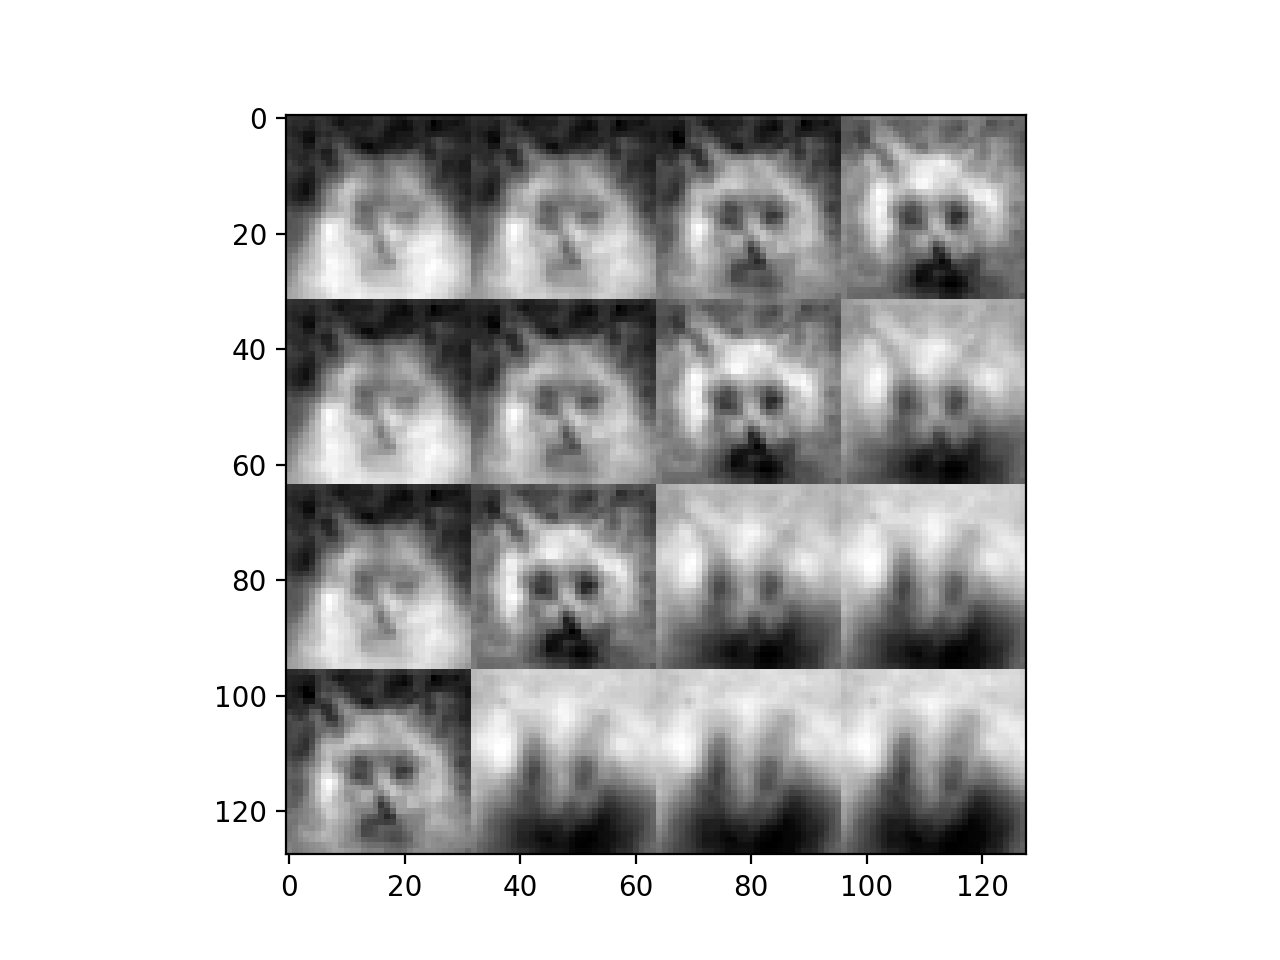

In [13]:
plt.imshow(img, cmap='gray')

注意したいのは顔の画像からは区別がつかないという結論にはならない。今回はかなり見た目を潰してしまっている。というのも、ピクセルごとの比較だから、黒い模様が丸い形とか耳の形が三角で、というような特徴は捉えていない。しかも背景の部分も比較しているから、単純にキツネの背景が白がちでタヌキやムジナは黒がちだった、という解釈も十分ありえるだろう。だとしても、キツネvs.タヌキの分かりやすさに対するタヌキvs.ムジナの分かりづらさは、デンドログラムでなかなか綺麗に分かれない結果からも支持できるのではないだろうか。